## Notebook for plotting generated dCS strain data

To see how to generate the strain from the command line, run

python3 ~/BeyondGR_PE/Generate_dCS_Strain.py -h

Then convert the strain using 

~/BeyondGR_PE/Convert_dCS_Strain data_dir res ell

In [1]:
# imports
# For downloading data
import sxs
from sxs import zenodo as zen
from matplotlib import rc

# For interacting with the data
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import json
from Generate_dCS_Strain import *
from scipy.signal import argrelextrema
rc('text', usetex=True)
from scipy.optimize import fmin

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


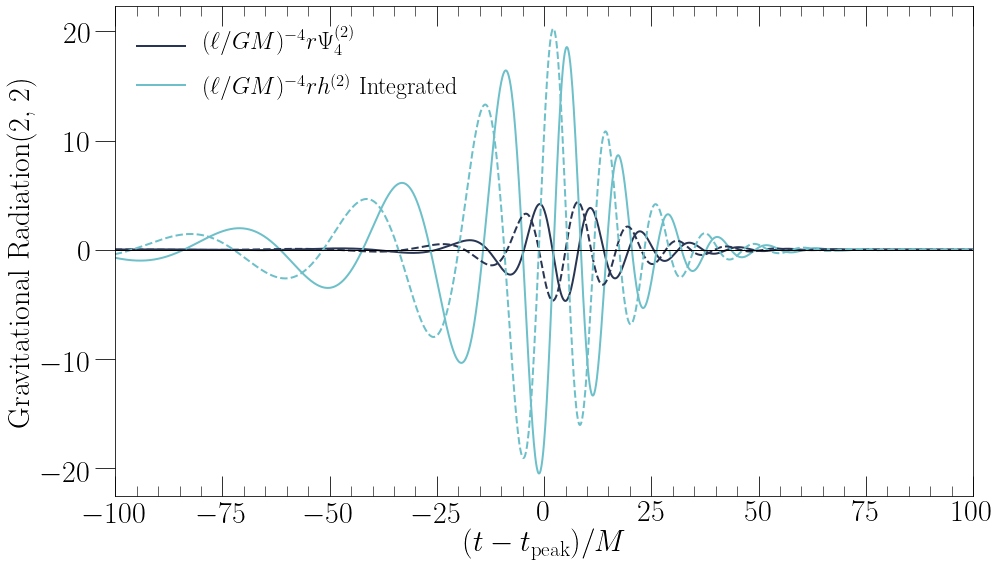

In [2]:
# The dCS correction to the strain 
def PlotDeltaStrain(start = -100, stop = 100):
    
    f, ax = plt.subplots(1, figsize=(14,8))
    mode = (2,2)
    order = 2
    p = "/Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev0/"

    ## Grab delta psi4 and compute delta h
    delta_time, delta_psi4 = ReadExtrapolatedMode(p, "DeltaPsi4", mode, order)
    delta_time, delta_strain = ComputeStrain(delta_time, delta_psi4, p)
    
    ## compute and subtract the peak time of delta h
    delta_time = SubtractPeakTimeMode(delta_time, delta_strain)

    ax.plot(delta_time, np.real(delta_psi4), label='$(\ell/GM)^{-4} r \Psi_4^{(2)}$', color='#283653', lw=2.0)
    ax.plot(delta_time, np.real(delta_strain), label='$(\ell/GM)^{-4} r h^{(2)} $ Integrated', \
            color='#6dc0c9', lw=2.0)
    ax.plot(delta_time, np.imag(delta_psi4), ls='--', color='#283653', lw=2.0)
    ax.plot(delta_time, np.imag(delta_strain), ls='--', color='#6dc0c9', lw=2.0)
    
    plt.axhline(0.0, color='black', lw=1.0)

    legend = ax.legend(fontsize=24, loc='upper left', frameon=False, ncol=1)
    ax.set_ylabel('Gravitational Radiation' + str(mode), fontsize=30)
    ax.set_xlim(start, stop)

    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    
    plt.tight_layout()
    plt.savefig('DeltaStrainComputation.pdf')
    plt.show()     

PlotDeltaStrain()

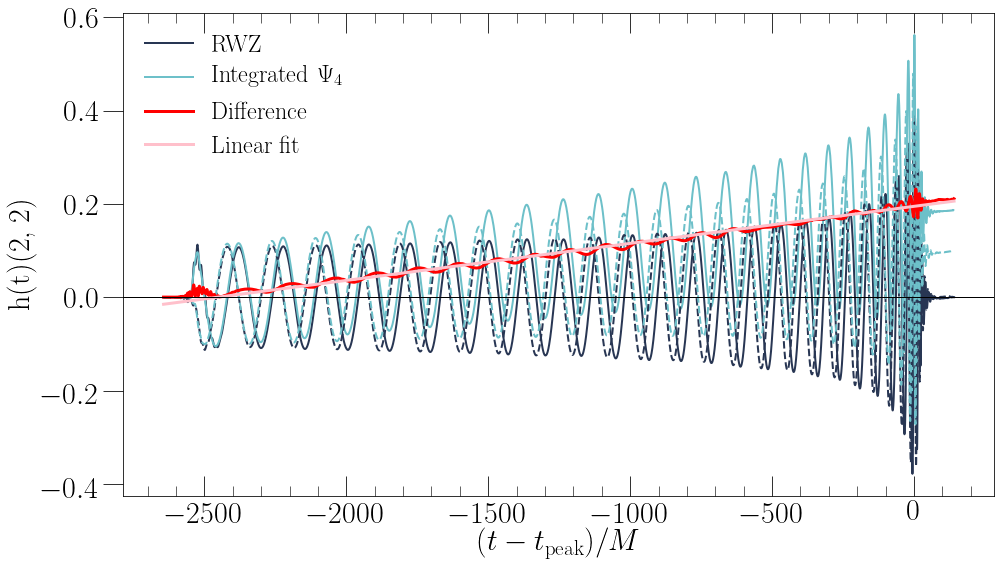

In [3]:
# Compare the two methods of computing the delta total strain
def PlotStrain(start = -100, stop = 100):
    
    f, ax = plt.subplots(1, figsize=(14,8))
    mode = (2,2)
    p = "/Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/"

    # Get background strain both ways
    time, strain = ReadExtrapolatedMode(p, "BackgroundStrain", mode)
    time2, strain2 = GetStrainFromPsi4(p, mode)
    
    ## compute and subtract the peak time of h
    time  = SubtractPeakTimeMode(time, strain)
    time2 = SubtractPeakTimeMode(time2, strain2)

    ax.plot(time, np.real(strain), label='RWZ', color='#283653', lw=2.0)
    ax.plot(time2, np.real(strain2), label='Integrated $\Psi_4$', color='#6dc0c9', lw=2.0)
    ax.plot(time, np.imag(strain), ls='--', color='#283653', lw=2.0)
    ax.plot(time2, np.imag(strain2), ls='--', color='#6dc0c9', lw=2.0)
    
    ## Fit linear trend to the difference
    diff = np.abs(strain - strain2)
    z = np.polyfit(time, diff, 1)
    p = np.poly1d(z)
    
    ax.plot(time, diff, color='red', label='Difference')
    ax.plot(time, p(time), label='Linear fit', color='pink')
    
    
    plt.axhline(0.0, color='black', lw=1.0)

    legend = ax.legend(fontsize=24, loc='upper left', frameon=False, ncol=1)
    ax.set_ylabel('h(t)' + str(mode), fontsize=30)
    #ax.set_xlim(start, stop)

    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    
    plt.tight_layout()
    plt.savefig('StrainComputation.pdf')
    plt.show()     

PlotStrain()

In [4]:
p = "/Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/"
OutputdCSModifiedStrain(p, 0.4, True)

Computing strain for l =  0.4
Computing for l = 2


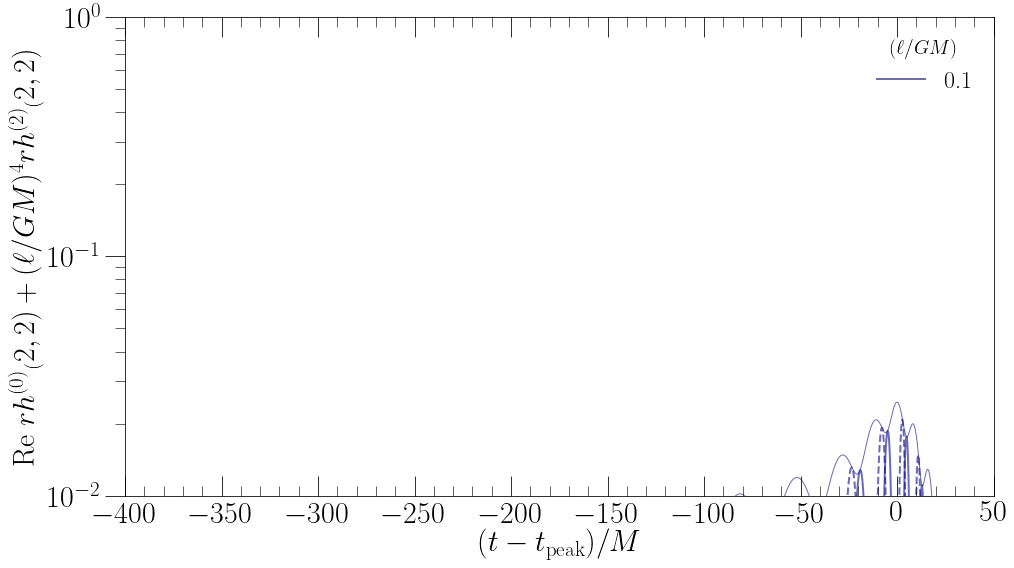

In [8]:
# Plot the gravitational wave strains together 
def StrainTogetherPlot(log=False): 
    
    p = "/Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/"
   
    f, ax = plt.subplots(1, figsize=(14,8))

    l_arr = [0.1] # , 0.05, 0.1, 0.15, 0.5]
    mode = (3,3)
    cmap = matplotlib.cm.get_cmap('plasma')
    colors = [cmap(float(i)/(len(l_arr))) for i in range(len(l_arr))][::-1]

    for l, color in zip(l_arr, colors):
        
        #time, total = ComputedCSModifiedStrain(p, mode, l)
        time, total = ReadExtrapolatedMode(p, "dCSModified", mode, ell=l)
        time = SubtractPeakTimeMode(time, total)
        ax.plot(time, np.abs(total), lw=1.0, color=color,alpha=0.6)
        ax.plot(time, np.real(total), lw=2.0, label=l, color=color,alpha=0.6)
        ax.plot(time, np.imag(total), lw=2.0, ls='--', color=color,alpha=0.6)
    legend = ax.legend(fontsize=24, loc='best', frameon=False, ncol=1 if log else 2, title='$(\ell/GM)$')
    plt.setp(legend.get_title(),fontsize=20)

    ax.set_ylabel('Re $rh^{(0)} {}_(2,2) + (\ell/GM)^4 rh^{(2)} {}_(2,2)$' , fontsize=30)
    ax.set_xlim(-400,50)
    #ax.set_xlim(2500, max(time))
    if log:
        #ax.set_xlim(2500, 2600)
        ax.set_ylim(1e-2, 1)
        ax.set_yscale('log')
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    
    plt.tight_layout()
    plt.savefig('StrainTogether.pdf' if not log else 'StrainTogetherLog.pdf')
    plt.show()   
    
#StrainTogetherPlot(log=False)
StrainTogetherPlot(log=True)

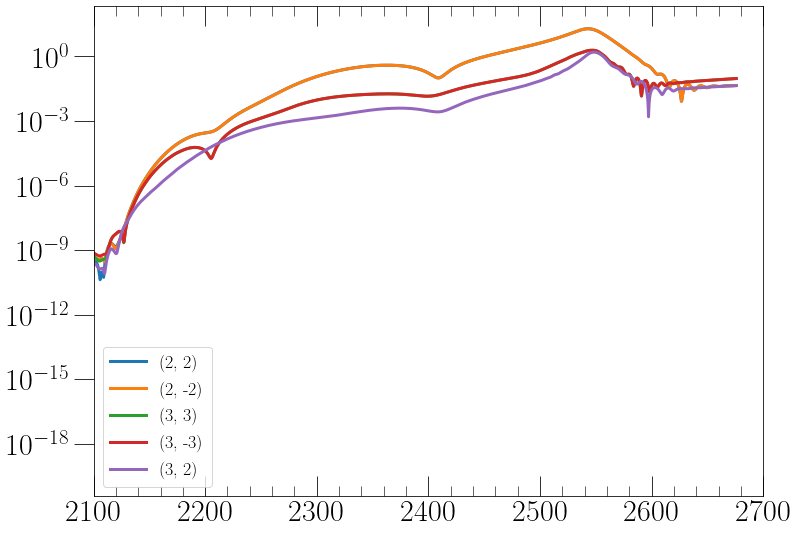

In [9]:
plt.figure(figsize=(12, 9))
p = "/Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/"

def method(mode):
    #time, strain, delta_strain = ComputedCSDeltaStrain(p, mode)
    time, delta_strain = ReadExtrapolatedMode(p, "DeltaStrain", mode)
    #time, delta_strain = ReadExtrapolatedMode(p, "BackgroundStrain", mode)
    plt.plot(time, np.abs(delta_strain), label=mode)
    #plt.plot(time, np.real(delta_strain))
    #plt.plot(time, np.imag(delta_strain))
    
#for l in range(2, 4):
#   for m in range(-l, l+1):
#       mode = (l, m)
#       method(mode)
modes = [(2,2), (2, -2), (3, 3), (3,-3), (3,2)]
for mode in modes:
    method(mode)
        
plt.xlim(2100, 2700)
plt.legend()
plt.yscale('log')
plt.show()

/Users/mokounkova/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


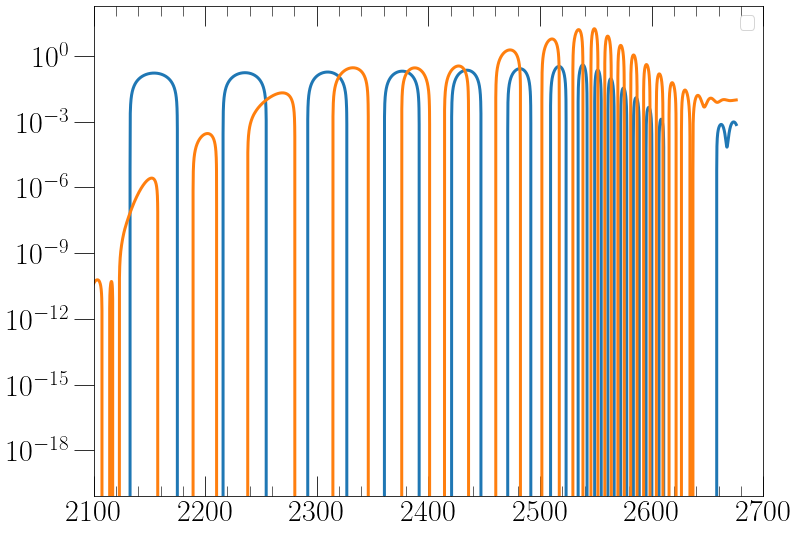

In [21]:
plt.figure(figsize=(12, 9))
p = "/Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/"

mode = (2,2)
time, background = ReadExtrapolatedMode(p, "BackgroundStrain", mode)
time, delta = ReadExtrapolatedMode(p, "DeltaStrain", mode)

plt.plot(time, background)
plt.plot(time, delta)
        
plt.xlim(2100, 2700)
plt.legend()
plt.yscale('log')
plt.show()

Reading in the LVC format strain from: /Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/Background_LVC.h5
Reading in the LVC format strain from: /Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/Delta0p9_LVC.h5
Reading in the LVC format strain from: /Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/Delta_LVC.h5


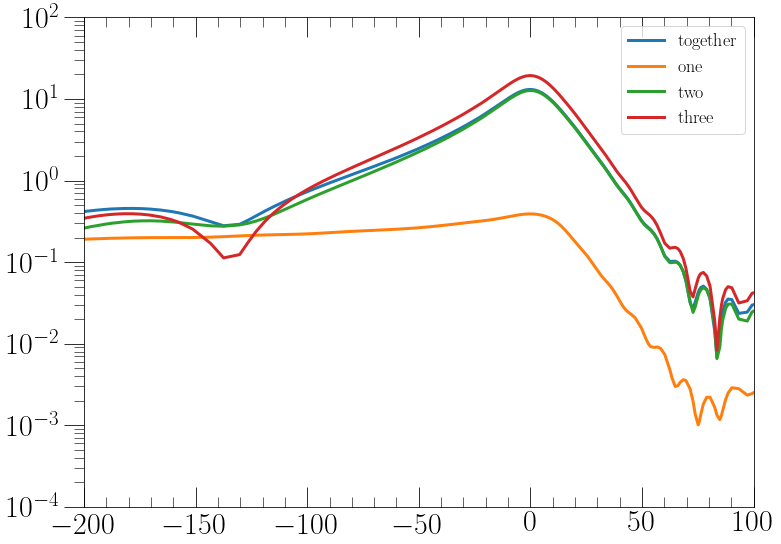

In [20]:
plt.figure(figsize=(12, 9))
p = "/Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/"

def MyReadLVCStrainMode(p, f, mode, order=2): 
    """ Read in the the phase and amplitude of the strain from 
        the LVC format file """
    l = mode[0]
    m = mode[1]
    h_file = p + f
    print("Reading in the LVC format strain from:", h_file)
    f = h5py.File(h_file, 'r')
    amp_dat = f["amp_l"+str(l)+"_m"+str(m)]
    phase_dat = f["phase_l"+str(l)+"_m"+str(m)]
    time = amp_dat['X']
    amp = amp_dat['Y']
    phase = phase_dat['X']
    return time, amp, phase

mode = (2,2)
ell = 0.9
t1, a1, p1 = MyReadLVCStrainMode(p, "Background_LVC.h5", mode)
t2, a2, p2 = MyReadLVCStrainMode(p, "Delta0p9_LVC.h5", mode)
t3, a3, p3 = MyReadLVCStrainMode(p, "Delta_LVC.h5", mode)

time = t1

a1 = InterpolateTimes(t1, a1, time)
a2 = InterpolateTimes(t2, a2, time)
a3 = InterpolateTimes(t3, a3, time)

plt.plot(time, a1 + 0.9**4*a3, label="together")

plt.plot(time, a1, label="one")
plt.plot(time, a2, label="two")
plt.plot(time, a3, label="three")

plt.xlim(-200, 100)
plt.ylim(1e-4, 1e2)

plt.yscale('log')

plt.legend()
plt.show()

In [11]:
# Compute mismatches

def DataForMismatch(p, l):
    mode = (2,2)
    time, total = ComputedCSModifiedStrain(p, mode, l)
    #time, total = ReadExtrapolatedMode(p, "BackgroundStrain", mode) ## to check
    gr_time, gr_total = ComputedCSModifiedStrain(p, mode, 0.0)
    
    
    ## Subtract peak times
    time = SubtractPeakTimeMode(time, total)
    gr_time = SubtractPeakTimeMode(gr_time, gr_total)
    
    return time, total, gr_time, gr_total
    
    
def ComputeMismatch(t_min, t_max):
    
    p = "/Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/"
    l = 0.226
    
    ## Get the data for computing the overlap
    for l in [0.0, 0.1, 0.2, 0.226]:
        time, total, gr_time, gr_total = DataForMismatch(p, l)
        overlap = ComputeMinOverlap(t_min, t_max, time, total, gr_time, gr_total)
        print(overlap)
    
ComputeMismatch(-1000, 150)
    

Computing strain for l =  0.0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
0.0
Computing strain for l =  0.0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
0.0
Computing strain for l =  0.0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
0.0
Computing strain for l =  0.0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
0.0


Reading in the LVC format strain from: /Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev2/dCS_ell_0p1.h5


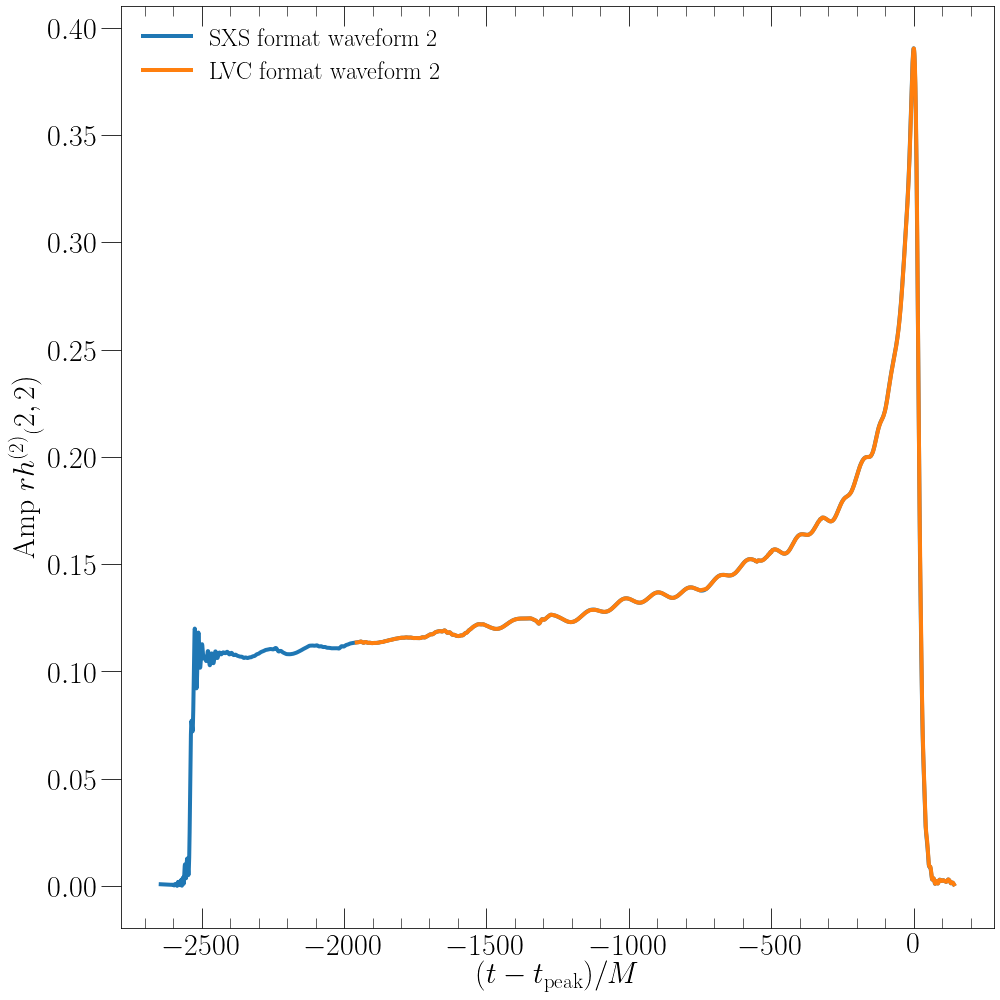

In [22]:
# Plot the LVC gravitational wave strains

def dCSStrainPlot(): 
    
    
    f, ax = plt.subplots(1, figsize=(14,14))

    l = 0.1

    for lev, lw in zip([2], [4.0, 1.0]):
        p = "/Users/mokounkova/dCS_LIGO_Data/BBH_SKS_2100/Lev" + str(lev) + "/"
        time, total = ReadExtrapolatedMode(p, "dCSModified",(2,2),ell=l)
        
        time = SubtractPeakTimeMode(time, total)
        ax.plot(time, np.abs(total), lw=lw, label='SXS format waveform ' + str(lev))

        ## Now get from the LVC file
        time, amp, phase = ReadLVCStrainMode(p, l, mode=(2,2))
        time = SubtractPeakTimeMode(time, amp)
        ax.plot(time, amp, lw=lw, label='LVC format waveform ' + str(lev))

    legend = ax.legend(fontsize=24, loc='best', frameon=False, ncol=1)
    plt.setp(legend.get_title(),fontsize=20)

    ax.set_ylabel('Amp $rh^{(2)} {}_(2,2)$' , fontsize=30)
    #ax.set_xlim(-50,50)
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    
    plt.tight_layout()
    plt.savefig('LVCFormat.pdf')
    plt.show()   
    
dCSStrainPlot()

In [ ]:
# Download the data we want from the catalog
## Both of these commands need to be run
# zen.download.matching("common-metadata.txt", "metadata.txt", "metadata.json", \
#                       "Horizons.h5", \
#                       sxs_ids = ['SXS:BBH:0305'], \
#                       dry_run = False, \
#                       highest_lev_only = False)
# zen.download.matching("rhOverM_Asymptotic_GeometricUnits_CoM.h5", \
#                       sxs_ids = ['SXS:BBH:0305'], \
#                       dry_run = False, \
#                       highest_lev_only = False)